In [19]:
import torch
from utils import models, nethook, activ, matching, helpers, dictionary, neuron_finding,cam
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [20]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def draw_bar_chart(label_number,pkl_file,save_path,methods="abs"):
    print(f"Draw bar chart for label {label_number}...")
    f = open(pkl_file,"rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()

    weights = data[:, :, 0]
    activation =data[:,:,2]

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        weights = np.abs(weights)
    weight_accumulator = np.sum(weights, axis=0)
    average_gradients = weight_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_gradients.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Weight for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"weight_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/weight_plot.png")

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        activation = np.abs(activation)
    activation_accumulator = np.sum(activation, axis=0)
    average_activation = activation_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_activation.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Activation for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"activation_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/activation_plot.png")

In [21]:
label = "all"
folder_path = f"/export/home/wuyueting/breast_data/BM/3_labelcroped/test/"
# model_name = "breast_vit_base_3"
# target_layer="model.blocks[-1].mlp.act"#"model.resnet.layer4[-1]" #"model.blocks[-1].mlp.act"
model_name = "breast_vit_base_3"
target_layer="model.blocks[-1].mlp.act"#"model.resnet.layer4[-1]" #"model.blocks[-1].mlp.act"
# model_name = "breast_effb0"
# target_layer = "efficientnet.features[-1]"

# target_save_name = model_name+target_layer
target_save_name = model_name+"_last_block_act"

In [22]:

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
def breast_main():
    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    # activ.get_same_class_similarity_matrix(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}_similarity.pkl")
    print(f"activs_stats/{target_save_name}/{label}.pkl")
    

    neuron_finding.visualize_all_neuron(model_name,target_layer,image_files,label,\
                                                                                        10,\
                                                                                        f"activs_stats/{target_save_name}",\
                                                                                        f"matching_result/{target_save_name}/{label}/",visualize=True)
    os.makedirs(f"matching_result/{target_save_name}/{label}", exist_ok=True)
    draw_bar_chart(label,f"activs_stats/{target_save_name}/{label}.pkl",save_path=f"matching_result/{target_save_name}/{label}",methods=None)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"
    if os.path.exists(f'predict_result/{model_name}_predictions.csv'):
        print(f'predict_result/{model_name}_predictions.csv exist!')
    else:
        model,_ = models.load(model_name, device)
        model.eval()

        preprocess =transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.22,), (0.08,))
            ])
        results = []
        for image_path in tqdm(image_files):
            image = Image.open(image_path)
            input_tensor = preprocess(image)
            input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
            output = model(input_tensor)
            BM = image_path.split("/")[-2]
            prediction = output.argmax(dim=1).item()
            # 将结果添加到DataFrame中
            results.append({'Image': image_path, 'BM': BM, 'Prediction': prediction})

        # 使用列表创建DataFrame
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'predict_result/{model_name}_predictions.csv', index=False)

    
    return

# breast_main()

In [23]:
import torch.nn as nn
from torchvision.transforms import ToPILImage
def breast_sample_explain(i,label,top_number:int=20,importance_matric = "ori_ori",revised=False):

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "cpu"
    # model,_ = models.load(model_name, device)
    # model.eval()

    preprocess =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.22,), (0.08,))
        ])
    

    if isinstance(i,str):
        index = image_files.index(i)
        image_path = i
        i = index
        del index
    else:
        image_path = image_files[i]
    print(image_path)
    
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    
    # 应用BatchNorm
    ori_gradients = data[i, :, 0]
    ori_activations = data[i, :, 2]
    label_dict,neuron_data = get_breast_sample_dict("biomedclip",ori_gradients,ori_activations,"BIRADS",top_number=top_number,importance_matric = importance_matric,only_pos=False)
    
    draw_new( label_dict, data ='BIRADS')
    
    # ##step3:得到分类
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.axis('off')  # 不显示坐标轴
    # plt.tight_layout()
    plt.show()
    
    if revised:
        description = input("请输入 description: ")
        # 筛选并排序
        filtered_df = neuron_data[neuron_data["description"] == description].sort_values(by="value", ascending=False)
    top_10_df = filtered_df.head(10)

    # 输出结果
    if not top_10_df.empty:
        print("筛选并排序后的前10个结果：")
        print(top_10_df)

        # 打开并显示对应的图片
        for idx, row in top_10_df.iterrows():
            # target_save_name = row["target_save_name"]
            neuron_id = row["neuron_id"]
            file_path = f"matching_result/{target_save_name}/all/Last_layer_{neuron_id}_neuron.png"

            # 检查文件是否存在，然后打开显示
            if os.path.exists(file_path):
                img = Image.open(file_path)
                plt.imshow(img)
                plt.axis('off')  # 隐藏坐标轴
                # plt.title(f"Neuron ID: {neuron_id}")
                plt.show()
            else:
                print(f"文件未找到：{file_path}")
    else:
        print("未找到匹配的 description")
    # input_tensor = preprocess(image)
    # input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
    # output = model(input_tensor)
    # prediction = output.argmax(dim=1).item()
    # if prediction == 0:
    #     print("It's a liang.")
    # elif prediction == 1:
    #     print("It's e.")
    
    # return sorted_result_dict

In [24]:
abbreviation_dict = {
    "rounded lesion": "RL",
    "oval lesion": "OL",
    "irregular lesion": "IRL",
    "lesion with circumscribed margin": "LCM",
    "lesion showing angular margins": "LAM",
    "lesion with microlobulated margins": "LMM",
    "lesion with spiculated margins": "LSM",
    "lesion with indistinct margins": "LIM",
    "lesion with distinct margins": "LDM",
    "lesion with surrounding echogenic halo": "LEH",
    "wider than tall lesion": "WTL",
    "taller than wide lesion": "TWL",
    "horizontal oriented lesion": "HOL",
    "vertical oriented lesion": "VOL",
    "wider than tall hypoechoic lesion": "WTHEL",
    "taller than wide hypoechoic lesion": "TWHL",
    "hypoechoic nonparallel lesion": "HNPL",
    "hypoechoic parallel lesion": "HPL",
    "hyperechoic lesion": "HEL",
    "isoechoic lesion": "ISEL",
    "hypoechoic lesion": "HYPL",
    "punctate calcified lesion": "PCL",
    "peripheral calcified lesion": "PeCL",
    "massive area calcified lesion": "MACL",
    "homogeneously non-calcified lesion": "HNCL",
    "homogeneous lesion": "HOML",
    "heterogeneous lesion": "HETL",
    "lesion with posterior shadowing": "LPS",
    "lesion with posterior enhancement": "LPE",
    "lesion with no posterior change": "LNPC",
    "small lesion": "SL",
    "medium lesion": "ML",
    "large lesion": "LL",
    "Undefined": "UN",
}


In [25]:
def get_categories_and_colormap_BIRADS():
    categories = {
    # Shape-related lesions
"Shape" : [
    "rounded lesion",
    "oval lesion",
    "irregular lesion"
],

# Margin-related lesions
"Margin" : [
    "lesion with circumscribed margin",
    "lesion showing angular margins",
    "lesion with microlobulated margins",
    "lesion with spiculated margins",
    "lesion with indistinct margins",
    "lesion with distinct margins"
],

# Halo-related lesion
"Halo" : [
    "lesion with surrounding echogenic halo"
],

# Orientation-related lesions
"Orientation" : [
    "wider than tall lesion",
    "taller than wide lesion",
    "horizontal oriented lesion",
    "vertical oriented lesion",
    "wider than tall hypoechoic lesion",
    "taller than wide hypoechoic lesion",
    "hypoechoic nonparallel lesion",
    "hypoechoic parallel lesion"
],

# Echo-related lesions
"Echo" : [
    "wider than tall hypoechoic lesion",
    "taller than wide hypoechoic lesion",
    "hypoechoic nonparallel lesion",
    "hypoechoic parallel lesion",
    "hyperechoic lesion",
    "isoechoic lesion",
    "hypoechoic lesion"
],

# Calcification-related lesions
"Calcification" : [
    "punctate calcified lesion",
    "peripheral calcified lesion",
    "massive area calcified lesion",
    "homogeneously non-calcified lesion",
],

# Homogeneity-related lesions
"Homogeneous" : [
    "homogeneous lesion",
    "heterogeneous lesion"
],

# Posterior feature-related lesions
"Posterior": [
    "lesion with posterior shadowing",
    "lesion with posterior enhancement",
    "lesion with no posterior change"
],

# Size-related lesions
"Size" : [
    "small lesion",
    "medium lesion",
    "large lesion"
]

}
    color_map = {
        'Shape': '#9184BF',
        'Margin': '#9184BF',
        'Halo': '#F9C0BC',
        'Orientation': '#E8B585',
        'Echo':'#EFB070',
        'Calcification': '#F2CA80',
        'Homogeneous': '#C1E6B0',
        'Posterior': '#6FC4A8',
        'Size':  '#ADD8E6',}
    return categories, color_map

In [ ]:
def get_filename(model_name,clipmodel_name):
    if clipmodel_name == "biomedclip":
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_15_44/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_16_44/descriptions.csv"
        # # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_16_27/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_03/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_12/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_12/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_05_16_35/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_05_18_03/descriptions.csv"
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_12/descriptions.csv"
        if model_name == "breast_vit_small_3":
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_small_3_24_09_09_11_20/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_small_3_24_09_09_15_03/descriptions.csv"
        if model_name == "breast_vit_base_3":
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_10_18_04/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_10_18_11/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_11_16_42/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_25_14_48/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_11_01_16_38/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_10_02_14_27/descriptions.csv"
        if model_name == "breast_vit_large_3":    
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_10_18_28/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_10_18_31/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_10_18_33/descriptions.csv"
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_13_14_43/descriptions.csv"
            
        if model_name == "breast_rn50_3":
            # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_10_18_37/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_10_18_43/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_13_15_33/descriptions.csv"
            filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_10_08_17_44/descriptions.csv"
    elif clipmodel_name == "vit":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_base_3_24_09_04_15_43/descriptions.csv" ##Vit-L/14
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_04_17_21/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_vit_large_3_24_09_05_15_02/descriptions.csv"
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/breast_rn50_3_24_09_05_16_33/descriptions.csv"
    return filename

In [27]:
def get_categories_and_colormap():
    categories = {
    # Tissue Composition
    "Tissue composition": [
        "homogeneously non-calcified lesion",
        "homogeneous lesion",
        "heterogeneous lesion"
    ],
    
    # Masses
    "Masses": [
        "rounded lesion",
        "oval lesion",
        "irregular lesion",
        "lesion with circumscribed margin",
        "lesion showing angular margins",
        "lesion with microlobulated margins",
        "lesion with spiculated margins",
        "lesion with indistinct margins",
        "lesion with distinct margins",
        "lesion with surrounding echogenic halo",
        "wider than tall lesion",
        "taller than wide lesion",
        "horizontal oriented lesion",
        "vertical oriented lesion",
        "hyperechoic lesion",
        "isoechoic lesion",
        "hypoechoic lesion",
        "wider than tall hypoechoic lesion",
        "taller than wide hypoechoic lesion",
        "hypoechoic nonparallel lesion",
        "hypoechoic parallel lesion",
        "lesion with posterior shadowing",
        "lesion with posterior enhancement",
        "lesion with no posterior change",
        "small lesion",
        "medium lesion",
        "large lesion"
    ],
    
    # Calcifications
    "Calcifications": [
        "punctate calcified lesion",
        "peripheral calcified lesion",
        "massive area calcified lesion"
    ]
    }
    #'#FFA07A', '#97C8AF', '#ADD8E6'
    color_map = {
        'Tissue composition': '#9392BE',
        'Masses': '#D0E7ED',
        'Calcifications':'#D5E4A8',
    }
    return categories, color_map


In [28]:
def get_categories_and_colormap_BM():
    categories = {
        # 良性特征
        "Benign": [
            "rounded lesion",
            "oval lesion",
            "wider than tall lesion",
            "horizontal oriented lesion",
            "wider than tall hypoechoic lesion",
            "hypoechoic parallel lesion",
            "hyperechoic lesion",
            "isoechoic lesion",
            "homogeneously non-calcified lesion",
            "homogeneous lesion",
            "lesion with circumscribed margin",
            "lesion with distinct margins",
            "lesion with surrounding echogenic halo",
            "punctate calcified lesion",
            "peripheral calcified lesion",
            "lesion with posterior enhancement",
            "small lesion",
            "medium lesion"
        ],

        # 恶性特征
        "Malignant": [
            "irregular lesion",
            "taller than wide lesion",
            "vertical oriented lesion",
            "hypoechoic lesion",
            "hypoechoic nonparallel lesion",
            "heterogeneous lesion",
            "lesion with spiculated margins",
            "lesion showing angular margins",
            "lesion with microlobulated margins",
            "lesion with indistinct margins",
            "massive area calcified lesion",
            "lesion with posterior shadowing",
            "large lesion",
            "taller than wide hypoechoic lesion",
        ],

        # 无明显倾向特征
        "Neutral": [
            
            "lesion with no posterior change",
            "lesion with surrounding echogenic halo"
        ]
    }

    # 颜色映射，增加新分类颜色
    color_map = {
        'Benign': '#ADD8E6',        # 蓝色
        'Malignant': '#FF7F7F',     # 红色
        'Neutral': '#BEB8DC'        # 紫色
    }

    return categories, color_map


In [29]:
def get_breast_sample_dict(clipmodel_name, ori_gradients, ori_activations,label_data="BIRADS", top_number:int=25,importance_matric = "abs_ori", only_pos=False):
    
    ## Standardization
    stn_gradients = ori_gradients/np.max(np.abs(ori_gradients))
    stn_activations = (ori_activations - np.min(ori_activations)) / (np.max(ori_activations) - np.min(ori_activations))
    abs_gradients = np.abs(ori_gradients)
        
    gradient_type = importance_matric.split("_")[0]
    activation_type = importance_matric.split("_")[1]

    if gradient_type == "abs":
        gradients = abs_gradients
    elif gradient_type == "stn":
        gradients = stn_gradients
    elif gradient_type == "ori":
        gradients = ori_gradients
    elif gradient_type == "stnabs":
        gradients = np.abs(stn_gradients)
    elif gradient_type =="sq":
        gradients = ori_gradients**2
        
    if activation_type == "stn":
        activations = stn_activations
    elif activation_type == "ori":
        activations = ori_activations
    elif activation_type == "abs":
        activations = np.abs(ori_activations)
    elif activation_type == "pos":
        min_act = np.min(ori_activations)
        if min_act < 0 :
            activations = ori_activations + np.abs(min_act)
        else:
            activations =  ori_activations
    elif activation_type == "sq":
        activations = ori_activations **2
        
    
    
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=top_number,only_pos=only_pos)
    positive_mask = top_k_values >= 0
    # 使用 np.argmax 找到第一个 False 的位置
    first_non_positive_index = np.argmax(~positive_mask)
    # 如果所有元素都是正数，则 np.argmax(~positive_mask) 将返回0（如果第一个元素为正数）
    # 需要检查是否所有元素都是正数
    if positive_mask.all():
        first_non_positive_index = len(top_k_values)
    
    
    filename = get_filename(model_name,clipmodel_name)
    df = pd.read_csv(filename)

    # print(filename)
    # unique_descriptions = set()
    sentence_parts = {}
    neuron_data = []
    
    categories, _ = get_categories_and_colormap_BIRADS()
    # categories, _ = get_categories_and_colormap_BM()
    for category, tags in categories.items():
        for tag in tags:
            sentence_parts[tag]=0
    total_value = 0
    for i in range(first_non_positive_index):
        id = top_important_idxs[i]
        value = top_k_values[i]
        target_row = df.iloc[id]
        description = target_row["description"] if target_row['similarity'] > 1 else "Undefined"
        if description not in sentence_parts:
            sentence_parts[description]=value
        else:
            sentence_parts[description]=sentence_parts[description]+value
        
        total_value = total_value + value
        neuron_data.append({"neuron_id": id, "description": description, "value": value})
    
    result_dict = {key: value / total_value for key, value in sentence_parts.items()}
    neuron_df = pd.DataFrame(neuron_data)

    del sentence_parts
    
    return result_dict, neuron_df

In [30]:
def draw_new(label_dict, data ='BIRADS'):
    
    categories, color_map = get_categories_and_colormap_BIRADS()
    # categories, color_map = get_categories_and_colormap_BM()
    # Assign colors to each row based on its category
    description_to_color = {}  # 描述到颜色的映射
    for category, items in categories.items():
        for item in items:
            description_to_color[item] = color_map[category]
    df_filtered = pd.DataFrame(list(label_dict.items()), columns=['description', 'values'])
    
    df_filtered['category_color'] = df_filtered['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    assert not df_filtered['category_color'].isna().any(), "在'category_color'列中存在NaN值"
    df_filtered = df_filtered[df_filtered['values']>0]
    df_filtered = df_filtered.sort_values(by=['category_color', 'values'], ascending=[True, False])
    bar_width=1
    positions = range(len(df_filtered['values']))
    # df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    # print(df_filtered)
    unique_colors = df_filtered['category_color'].unique()
    color_blocks = {color: [] for color in unique_colors}
    last_color = None
    for i, (color, count) in enumerate(zip(df_filtered['category_color'], df_filtered['values'])):
        if color != last_color:
            if last_color is not None:
                color_blocks[last_color][-1].append(i)  # End position of the last block
            color_blocks[color].append([i])  # Start position of the new block
            last_color = color
    color_blocks[last_color][-1].append(i + 1)  # End position of the last block

    
    df_filtered['abbreviation'] = df_filtered['description'].map(abbreviation_dict)
    # print(df_filtered)
    
    max_values_by_color = df_filtered.loc[df_filtered.groupby('category_color')['values'].idxmax()]

    # 格式化输出
    formatted_output = max_values_by_color.apply(lambda row: f"{row['description']}({row['values']:.2%})", axis=1).tolist()

    # 打印结果
    for item in formatted_output:
        print(item+",")
    
    df_filtered = df_filtered[df_filtered['description']!="Undefined"]
    # print(df_filtered)
    plt.figure(figsize=(len(df_filtered['values'])//2, 2.5))
    plt.bar(df_filtered['abbreviation'], df_filtered['values'], color=df_filtered['category_color'],width=0.9, align='center')
    
    # plt.bar(df_filtered['description'], df_filtered['values'], color=df_filtered['category_color'],align='edge')

    # Add shaded regions for each color block
    for color, blocks in color_blocks.items():
        for start, end in blocks:
            plt.axvspan(start-0.45, end-0.55 , color=color, alpha=0.4,linewidth=0)
            
    # # 添加图例到图表
    # plt.legend(handles=legend_handles, title="Categories",framealpha=1.0, facecolor='white', loc='right')

    # plt.title('Number of Neuron per Description')
    plt.xticks(rotation=60, ha='right')
    # plt.subplots_adjust(left=-0.05)
    plt.tick_params(axis='y', which='both', pad=2)
    plt.tick_params(axis='x', which='both', length=0)  # 隐藏x轴的刻度线但保留标签
    plt.tick_params(axis='y', which='both', length=0)  # 隐藏y轴的刻度线    
    plt.xlim(-0.5, len(df_filtered['abbreviation']) - 0.5)
    # 去掉边框
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    # 显示图表
    # plt.savefig(f'layer{number}.pdf', format='pdf', transparent=True)
    plt.show()
    return

activs_stats/breast_vit_base_3_last_block_act/all.pkl exist!
/export/home/wuyueting/breast_data/BM/3_labelcroped/test/1/BIC_0541.jpg
lesion with no posterior change(0.49%),
lesion with spiculated margins(19.79%),
large lesion(3.75%),
heterogeneous lesion(10.95%),
wider than tall lesion(1.26%),
taller than wide hypoechoic lesion(11.31%),
massive area calcified lesion(4.66%),
lesion with surrounding echogenic halo(1.55%),
Undefined(21.83%),


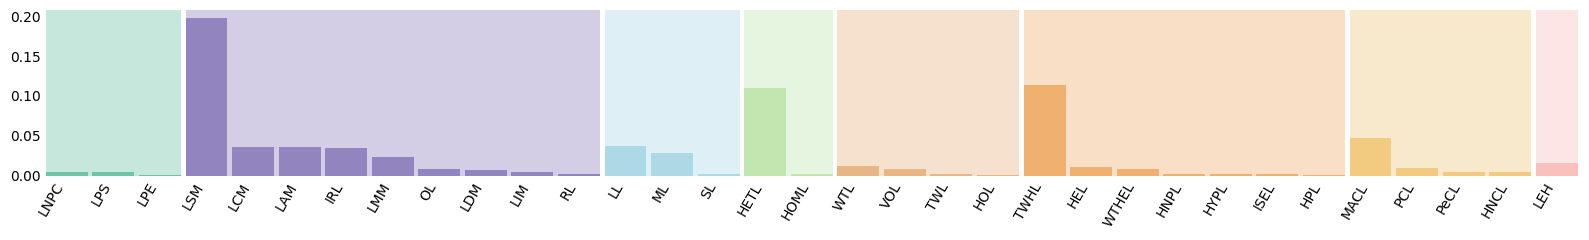

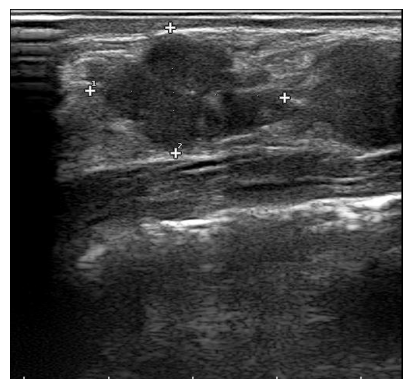

筛选并排序后的前10个结果：
     neuron_id                    description         value
5         1810  massive area calcified lesion  1.432748e-07
17         567  massive area calcified lesion  8.361973e-08
57        2930  massive area calcified lesion  3.418422e-08
79        1876  massive area calcified lesion  2.676532e-08
93         427  massive area calcified lesion  2.298501e-08
135        644  massive area calcified lesion  1.479777e-08
154       1103  massive area calcified lesion  1.303437e-08
224        797  massive area calcified lesion  7.905052e-09
253         28  massive area calcified lesion  6.529677e-09
260       2173  massive area calcified lesion  6.326812e-09


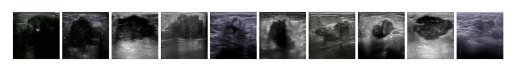

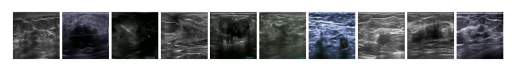

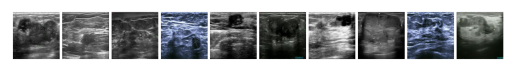

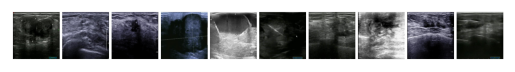

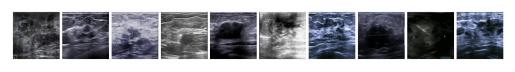

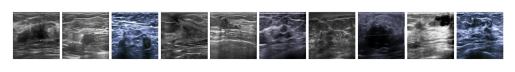

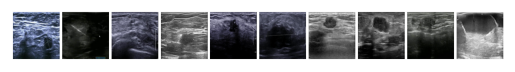

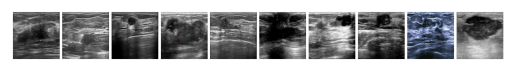

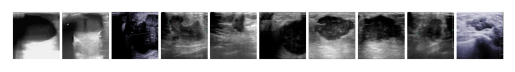

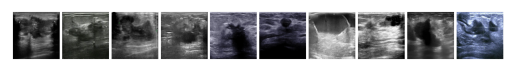

In [31]:
breast_sample_explain(210,"all",top_number=2000,importance_matric="abs_stn",revised=True)

## BIRADS3

In [32]:
from sklearn.metrics import roc_curve
def label_auc(label_data="BIRADS",top_number =100, importance_matric = "abs_stn",batch_norm=True, clipmodel = "biomedclip"):

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    tag_csv="/export/home/wuyueting/breast_data/test.csv"
    tag_df = pd.read_csv(tag_csv)
    
    num = tag_df.shape[0]
    
    ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues, shape_trues,density_trues = [], [], [], [], [], [],[]
    ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores, shape_scores,density_scores = [], [], [], [], [], [], []
    
    # if batch_norm== True:
    # print("batch norm is ",batch_norm)
    # batch_norm1 = nn.BatchNorm1d(num_features=384)
    # batch_norm2 = nn.BatchNorm1d(num_features=384)
    # print(np.mean(data[:, :, 2]),np.var(data[:, :, 2]),np.mean(data[:, :, 0]),np.var(data[:, :, 0]))
    # #应用BatchNorm
    # norm_activation = batch_norm1(torch.from_numpy(data[:, :, 2]).cpu().float()).detach().numpy()
    # norm_gradient = batch_norm2(torch.from_numpy(data[:, :, 0]).cpu().float()).detach().numpy()
    # print(np.mean(norm_activation),np.var(norm_activation),np.mean(norm_gradient),np.var(norm_gradient))
    
    for i in range(num):
        image_name = tag_df.iloc[i, 0]
        BM = tag_df.iloc[i, 1]
        image_path = os.path.join("/export/home/wuyueting/breast_data/BM/3_labelcroped/test/",str(BM), image_name)
        # 
        if image_path not in image_files:
            continue
        
        index = image_files.index(image_path)
        # if batch_norm== True:
        #     ori_activations = norm_activation[index,:]
        #     ori_gradients = norm_gradient[index,:]
        # else:
        ori_gradients = data[index, :, 0]
        ori_activations = data[index, :, 2]
        # print(ori_activations,ori_gradients)
        label_dict,_ = get_breast_sample_dict(clipmodel,ori_gradients,ori_activations,label_data,top_number=top_number,importance_matric = importance_matric,only_pos=False)
        categories, _ = get_categories_and_colormap(label_data)
        # print(label_dict)
        organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}
        if not pd.isnull(tag_df.loc[i, 'Ratio']):
            ratio_trues.append(tag_df.loc[i, 'Ratio'])
            ratio_dict = organized_data['Ratio']
            if sum(ratio_dict.values())==0:
                ratio = 0
            else:
                ratio = (ratio_dict["non-parallel nodule"]+ratio_dict["longitudinal nodule"]+ratio_dict["taller-than-wide nodule"]+ratio_dict["vertically elongated nodule"])/sum(ratio_dict.values())
                # ratio = (ratio_dict["taller-than-wide nodule"]+ratio_dict["longitudinal nodule"])/(ratio_dict["transverse nodule"]+ratio_dict["longitudinal nodule"]+ratio_dict["taller-than-wide nodule"]+ratio_dict["wider-than-tall nodule"])
            # ratio = (ratio_dict["taller-than-wide nodule"])/(+ratio_dict["taller-than-wide nodule"]+ratio_dict["wider-than-tall nodule"])
            
            ratio_scores.append(ratio)
        
        composition_dict = organized_data['Composition']
        if not pd.isnull(tag_df.loc[i, 'Composition']):
            composition_trues.append(tag_df.loc[i, 'Composition'])
            if sum(composition_dict.values())==0:
                composition = 0
            else:
                composition = (composition_dict["solid nodule"]+composition_dict["mixed cystic-solid nodule"]+composition_dict["mixed cystic/solid nodule"])/(sum(composition_dict.values()))
            composition_scores.append(composition)
            
        if not pd.isnull(tag_df.loc[i, 'Margin']):
            margin_trues.append(tag_df.loc[i, 'Margin'])
            margin_dict = organized_data['Margin']
            if sum(margin_dict.values()) == 0:
                margin = 0
            else:
                margin = (sum(margin_dict.values())-margin_dict["marginal well-circumscribed nodule"]-margin_dict["marginal distinct nodule"]-margin_dict["marginal smooth nodule"]-margin_dict["marginal ill-defined nodule"])/sum(margin_dict.values())
            margin_scores.append(margin)
            
        if not pd.isnull(tag_df.loc[i,"Echo"]):
            echo_trues.append(tag_df.loc[i, 'Echo'])
            echo_dict = organized_data["Echo"]
            if (sum(echo_dict.values())) ==0:
                echo = 0
            else:
                echo =  (echo_dict["hypoechoic echo nodule"]+echo_dict["heterogeneous echo nodule"])/(sum(echo_dict.values()))
            echo_scores.append(echo)
            
            # density_dict = organized_data["Density"]
            # density_trues.append(tag_df.loc[i,"Echo"])
            # if sum(density_dict.values())==0:
            #     density = 0
            # else:
            #     density = density_dict["middle-density nodule"]/sum(density_dict.values())
            # density_scores.append(density)
            
        if not pd.isnull(tag_df.loc[i, 'Calcification']):
            cal_trues.append(tag_df.loc[i, 'Calcification'])
            cal_dict = organized_data['Calcification']
            if sum(cal_dict.values()) == 0:
                cal = 0
            else:
                cal = (sum(cal_dict.values())-cal_dict["homogeneously non-calcified nodule"])/((sum(cal_dict.values())))
            cal_scores.append(cal)
        
        if not pd.isnull(tag_df.loc[i, 'Shape']):
            shape_trues.append(tag_df.loc[i, 'Shape'])
            shape_dict = organized_data['Shape']
            if (shape_dict["irregular shape nodule"]+shape_dict["regular shape nodule"]) == 0:
                shape = 0
            else:
                shape =shape_dict["irregular shape nodule"]/(shape_dict["irregular shape nodule"]+shape_dict["regular shape nodule"])
            shape_scores.append(shape)
        
        del label_dict, categories, organized_data
            
    # ratio_preds = [0 if x<0.5 else 1 for x in ratio_scores]
    # composition_preds = [0 if x<0.5 else 1 for x in composition_scores]
    # margin_preds = [0 if x<0.5 else 1 for x in margin_scores]
    # echo_preds = [0 if x<0.5 else 1 for x in echo_scores]
    
    # 计算ACC
    scores = [ratio_scores, margin_scores, echo_scores, cal_scores,shape_scores]
    trues = [ratio_trues,  margin_trues, echo_trues, cal_trues, shape_trues]
    categories = ['Ratio',  'Margin', 'Echo', "Calcification", "Shape"]

    # 循环遍历每一组评分和真实值
    for category, true_values, pred_scores in zip(categories, trues, scores):
        # 计算预测值
        # true_values_series = pd.Series(true_values)
        # pred_scores_series = pd.Series(pred_scores)

        # # 检查哪些位置有NaN
        
        # true_values = true_values_series.fillna(0)
        # pred_scores = pred_scores_series.fillna(0)
        
        preds = [0 if x < 0.5 else 1 for x in pred_scores]
        # 计算准确率和AUC
        acc = accuracy_score(true_values, preds)
        auc = roc_auc_score(true_values, pred_scores)
        print(pred_scores)
        # 打印结果
        print(f"{category} Accuracy: {acc:.3f}")
        print(f"{category} AUC: {auc:.3f}")
        # # 计算ROC曲线的坐标点
        # fpr, tpr, thresholds = roc_curve(true_values, pred_scores)

        # # 绘制ROC曲线
        # plt.figure()
        # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlim([0.0, 1.0])
        # plt.ylim([0.0, 1.05])
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('Receiver Operating Characteristic')
        # plt.legend(loc="lower right")
        # plt.show()

In [33]:
# label_auc(label_data="BIRADS",top_number =600, importance_matric = "abs_stn",clipmodel="biomedclip",batch_norm=False)

In [34]:
import matplotlib
from matplotlib.ticker import FuncFormatter
def custom_formatter(y, pos):
    if y < 0:
        return f'{-y:.0e}'  # 负值显示为-1
    else:
        return f'{y:.0e}'  # 正值显示为两位小数
def breast_global_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[IMAGE, NEURON, 3],3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [],[]
    for index, row in prediction_csv.iterrows():
        if row['BM']==0 and row['Prediction'] == 0:
            result_0.append(data[index,:,:])
        elif row['BM'] ==1 and row['Prediction'] == 1:
            result_1.append(data[index,:,:])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    filename = get_filename(model_name,'biomedclip')
    df_clip = pd.read_csv(filename)
    df_group = [df_0,df_1]
    # column_names = ['col0', 'col1']
    for i in range(2):
        class_df = df_group[i]
        ori_activations = class_df[:, :, 2]
        abs_gradient = np.abs(class_df[:,:,0])
        
        # 计算每个图像的最大值和最小值
        min_activations = np.min(ori_activations, axis=1, keepdims=True)
        max_activations = np.max(ori_activations, axis=1, keepdims=True)

        # 进行归一化操作
        normalized_activations = (ori_activations - min_activations) / (max_activations - min_activations)
        elementwise_product = abs_gradient * normalized_activations
        # 对每个神经元上的所有数值进行求和
        sum_per_neuron = np.sum(elementwise_product, axis=0)/elementwise_product.shape[0]
        df_clip[str(i)] = sum_per_neuron
        # 打印结果
    
    df_clip_filtered = df_clip[df_clip['similarity'] >1]
    df_clip_filtered =df_clip_filtered[['0','1','description']]
    # 按照 description 把相同的 description 的 "0" 和 "1" 的值相加
    df_clip_filtered['abbr'] =  df_clip_filtered['description'].map(abbreviation_dict)
    result = df_clip_filtered.groupby('abbr').sum()
    result['abbr'] = result.index
    # result.set_index('abbr', inplace=True)
    


    index = np.arange(len(result))

    # 设置图形的大小
    fig, ax = plt.subplots(figsize=(16, 4))  # 宽度为10英寸，高度为6英寸
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   
    # 设置条形宽度和偏移量
    bar_width = 0.35  # 条形的宽度
    offset = 0.17     # 每组条形之间的偏移量
    # 绘制 '1' 列的条形图
    # ax.bar(index, np.array(result['1']),label='Malignant', facecolor='#F39808', edgecolor='black') ##F0907E

    # # 绘制 '0' 列的条形图，使用负值使其显示在左侧
    # ax.bar(index, 1*np.array(result['0']), label='Benign', facecolor='#91BFFA', edgecolor='black')
    # ax.axhline(0, color='black', linewidth=1, linestyle='-')
    ax.bar(index - offset, np.array(result['1']), width=bar_width, label='Malignant', facecolor='#F39808', edgecolor='black')

    # 绘制 '0' 列的条形图（良性），正值
    ax.bar(index + offset, np.array(result['0']), width=bar_width, label='Benign', facecolor='#91BFFA', edgecolor='black')

    ax.axhline(0, color='black', linewidth=1, linestyle='-')
    # 设置 x 轴的显示范围
    ax.set_xlim(-1, len(result))

    # 设置 x 轴的刻度标签
    ax.set_xticks(index)
    ax.set_xticklabels(result.index, rotation=60)
    
    # max_val = max(max(result['1']), -min(result['0']))  # 找到最大的绝对值
    # y_ticks = np.linspace(-max_val, max_val, num=10)  # 创建10个刻度
    # ax.set_yticks(y_ticks)

    # # 使用 FuncFormatter 格式化 y 轴标签为科学计数法
    # def sci_format(x, pos):
    #     return f"{abs(x):.1e}"

    # formatter = FuncFormatter(sci_format)
    # ax.yaxis.set_major_formatter(formatter)
    ax.legend()
    fig.patch.set_alpha(0.0)
    # ax.set_facecolor('none')
    # 显示图表
    plt.show()
    fig.savefig('test.png', bbox_inches='tight',transparent = True)
# breast_global_explain()   

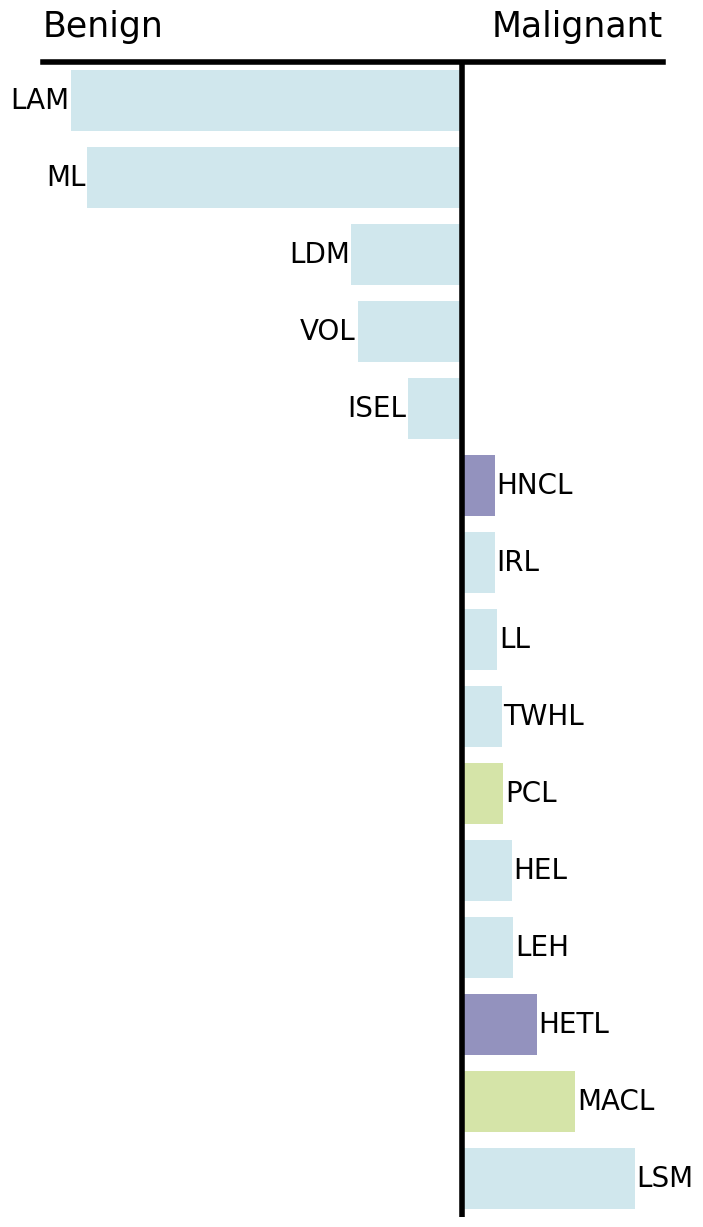

In [35]:
def breast_concept_level_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[IMAGE, NEURON, 3],3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [],[]
    for index, row in prediction_csv.iterrows():
        if row['BM']==0 and row['Prediction'] == 0:
            result_0.append(data[index,:,:])
        elif row['BM'] ==1 and row['Prediction'] == 1:
            result_1.append(data[index,:,:])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    filename = get_filename(model_name,'biomedclip')
    df_clip = pd.read_csv(filename)
    df_group = [df_0,df_1]
    # column_names = ['col0', 'col1']
    for i in range(2):
        class_df = df_group[i]
        ori_activations = class_df[:, :, 2]
        abs_gradient = np.abs(class_df[:,:,0])
        
        # 计算每个图像的最大值和最小值
        min_activations = np.min(ori_activations, axis=1, keepdims=True)
        max_activations = np.max(ori_activations, axis=1, keepdims=True)

        # 进行归一化操作
        normalized_activations = (ori_activations - min_activations) / (max_activations - min_activations)
        elementwise_product = abs_gradient * normalized_activations
        # 对每个神经元上的所有数值进行求和
        sum_per_neuron = np.sum(elementwise_product, axis=0)/elementwise_product.shape[0]
        df_clip[str(i)] = sum_per_neuron
        # 打印结果
    
    # print(df_clip)
    df_clip["expression_difference"] = np.log(np.array(df_clip['1']) / (np.array(df_clip['0'])))
    
    categories,color_map = get_categories_and_colormap()
    description_to_color = {}  # 描述到颜色的映射
    for category, items in categories.items():
        for item in items:
            description_to_color[item] = color_map[category]
            
    df_clip_filtered = df_clip[df_clip['similarity'] >0]
    # df_clip_filtered['category_color'] = df_clip_filtered['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    df_clip_filtered =df_clip_filtered[['0','1','description',"expression_difference"]]
    # 按照 description 把相同的 description 的 "0" 和 "1" 的值相加
    # df_clip_filtered['abbr'] =  df_clip_filtered['description'].map(abbreviation_dict)
    result = df_clip_filtered.groupby('description').sum()
    result['description'] = result.index
    result['abbr'] =  result['description'].map(abbreviation_dict)
    result = result.sort_values(by='expression_difference', ascending=False)
    result['category_color'] = result['description'].apply(lambda x: description_to_color.get(x, 'grey'))
    
    # result["expression_difference"]= np.log(np.array(result['1']) / (np.array(result['0']) + 1e-20))
    
    result_sorted = result.sort_values(by='expression_difference', ascending=False)

    # 分别筛选出大于0和小于0的前5名
    top_positive = result_sorted[result_sorted['expression_difference'] > 0].head(10)
    top_negative = result_sorted[result_sorted['expression_difference'] < 0].tail(5)

    # 合并这两个 DataFrame
    top_results = pd.concat([top_positive, top_negative])[['0','1','abbr',"expression_difference",'category_color']]
    # print(top_results)
    
    fig, ax = plt.subplots(figsize=(8,len(top_results)))  # 宽度为8英寸，高度为12英寸

    # 设置条形宽度
    bar_width = 0.8

    # 绘制 'expression_difference' 列的条形图
    index = np.arange(len(top_results))
    bars = ax.barh(index, top_results['expression_difference'], height=bar_width, color=top_results['category_color'])
    for bar, val, abbr in zip(bars, top_results['expression_difference'], top_results['abbr']):

            # 在柱形旁边添加缩写
            ax.text(val + 1 if val > 0 else val - 1, bar.get_y() + bar.get_height() / 2, abbr,
                    va='center', ha='left' if val > 0 else 'right', fontsize=20, color='black')

    ax.axvline(0, color='black', linewidth=4, linestyle='-')
    
    # 去掉左右和下方边框
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_linewidth(4)
    # ax.spines['top'].set_visible(False)  # 如果你想去掉顶部边框，可以取消注释
    
    # 将 x 轴的刻度和标签移动到顶部
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    ax.xaxis.set_ticks([])  # 隐藏刻度线
    ax.xaxis.set_tick_params(size=0)  # 隐藏刻度线的长度
    ax.tick_params(axis='x', labelsize=12)  # 设置刻度数字的大小
    
    
    xmin, xmax = ax.get_xlim()

    # 获取 y 轴的最大值并稍微减少以靠近顶部轴线
    y_pos = ax.get_ylim()[1] - 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 减少一点高度，贴近 ax.spines['top']

    # 在 x 轴左边写 'benign'
    ax.text(xmin, y_pos+0.2, 'Benign', 
            horizontalalignment='left', 
            verticalalignment='top',  # 使用 'top' 让文本顶部贴近 y_pos
            fontsize=25)

    # 在 x 轴右边写 'malignant'
    ax.text(xmax, y_pos+0.2, 'Malignant', 
            horizontalalignment='right', 
            verticalalignment='top',  # 使用 'top' 让文本顶部贴近 y_pos
            fontsize=25)


    ax.set_yticks([])  # 去掉 y 轴的刻度
    ax.set_yticklabels([])  # 去掉 y 轴的刻度标签
    
    y_num=np.arange(len(top_results))
    ax.set_ylim(0, 30) 
    ax.set_ylim(min(y_num)-0.5,max(y_num)+0.5)

    # ax.set_title('Expression Difference (Malignant vs. Benign)', fontsize=16)

    plt.show()

    fig.savefig('test_vertical.png',dpi=330, bbox_inches='tight', transparent=True)
breast_concept_level_explain()   

In [36]:
import numpy as np
import pandas as pd
import pickle

def breast_neuron_level_explain():
    f = open(f"activs_stats/{target_save_name}/{label}.pkl", "rb")
    data = pickle.load(f)  # [IMAGE, NEURON, 3], 3:[weights, max_activations, mean_activations]
    f.close()
    
    prediction_csv = pd.read_csv(f'predict_result/{model_name}_predictions.csv')
    
    result_0, result_1 = [], []
    for index, row in prediction_csv.iterrows():
        if row['BM'] == 0 and row['Prediction'] == 0:
            result_0.append(data[index, :, :])
        elif row['BM'] == 1 and row['Prediction'] == 1:
            result_1.append(data[index, :, :])
    
    df_0 = np.array(result_0)
    df_1 = np.array(result_1)
    
    # 提取神经元激活值，索引 2 对应 mean_activations
    activations_0 = df_0[:, :, 2]  # [样本数, 神经元数]
    activations_1 = df_1[:, :, 2]  # [样本数, 神经元数]

    # 计算每个神经元在两类中的平均激活值
    mean_activation_0 = activations_0.mean(axis=0)  # [神经元数]
    mean_activation_1 = activations_1.mean(axis=0)  # [神经元数]

    # 计算类别 1 和类别 0 之间的激活差异
    activation_diff = mean_activation_1 - mean_activation_0

    # 找到激活差异最大的前十名神经元
    top_indices = np.argsort(np.abs(activation_diff))[-10:][::-1]  # 获取前十名索引

    for i, index in enumerate(top_indices):
        print(f"第 {i + 1} 名: 神经元 {index}")
        print(f"该神经元在类别 0 上的平均激活值：{mean_activation_0[index]}")
        print(f"该神经元在类别 1 上的平均激活值：{mean_activation_1[index]}")
        print(f"激活差异（类别 1 - 类别 0）：{activation_diff[index]}")
        print()

breast_neuron_level_explain()


第 1 名: 神经元 2384
该神经元在类别 0 上的平均激活值：5.846511242163443
该神经元在类别 1 上的平均激活值：0.10425530790875775
激活差异（类别 1 - 类别 0）：-5.742255934254685

第 2 名: 神经元 2887
该神经元在类别 0 上的平均激活值：0.046171698364228214
该神经元在类别 1 上的平均激活值：4.651555059891608
激活差异（类别 1 - 类别 0）：4.60538336152738

第 3 名: 神经元 2133
该神经元在类别 0 上的平均激活值：4.791442075785059
该神经元在类别 1 上的平均激活值：0.3349706578430616
激活差异（类别 1 - 类别 0）：-4.456471417941997

第 4 名: 神经元 2990
该神经元在类别 0 上的平均激活值：0.12114300289929311
该神经元在类别 1 上的平均激活值：4.53384106606245
激活差异（类别 1 - 类别 0）：4.412698063163157

第 5 名: 神经元 340
该神经元在类别 0 上的平均激活值：0.005459672950809781
该神经元在类别 1 上的平均激活值：4.38283048552047
激活差异（类别 1 - 类别 0）：4.37737081256966

第 6 名: 神经元 663
该神经元在类别 0 上的平均激活值：4.4205837336769935
该神经元在类别 1 上的平均激活值：0.04627421629305376
激活差异（类别 1 - 类别 0）：-4.3743095173839395

第 7 名: 神经元 805
该神经元在类别 0 上的平均激活值：4.125003228222367
该神经元在类别 1 上的平均激活值：0.03560574404198431
激活差异（类别 1 - 类别 0）：-4.089397484180383

第 8 名: 神经元 294
该神经元在类别 0 上的平均激活值：0.024165303326963046
该神经元在类别 1 上的平均激活值：4.05130133094887
激活差异（类别 1 - 类别 0）：4.02